<a href="https://colab.research.google.com/github/emkalan/comp215/blob/main/labs/lab08_GoL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name:
#### Date:

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [2]:
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [3]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [46]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show(block=True)               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

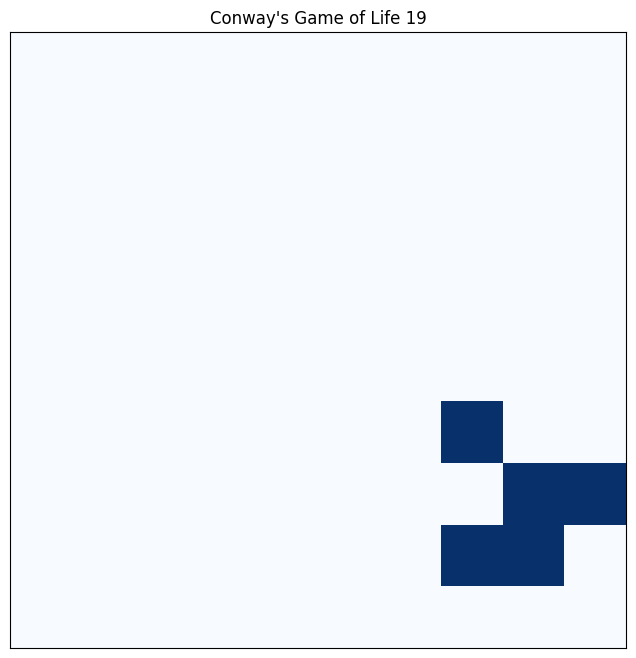

In [6]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
Write a line or 2 of code to compute and print the answer for each question:
* how many unique states are there for a 3x3 (9 cell) neighbourhood?
* how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
* how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)

In [7]:
# Ex. 1 your code here...

unique_states = 2**9
print(f"Unique states: {unique_states}")
unique_rules = 2**unique_states
print(f"Unique rules: {unique_rules}")
atoms_in_universe = 10**80
print(f"Unique rules are much larger than the estimated number of atoms in the universe: {unique_rules > atoms_in_universe}")

Unique states: 512
Unique rules: 13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096
Unique rules are much larger than the estimated number of atoms in the universe: True


Using what you learned above, concisely answer each question below (point form)1
1. would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
2. propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
3. how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

#### Ex 1. Your Answers

1. No sorry. there are way too many.
2. Um... do each rule as a binary number where each bit corresponds to the output for a specific neighbourhood state
3. first ... generate all 512 possible 3x3 neighbourhood configs
then ... determine the next state of the center cell based on Conway GoL rules
then ... create a binary number where each bit represents the output for a corresponding state
then you can get the corresponding decimal number.

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in previous lab

In [44]:
# Ex. 2 experimental setup

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """
    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        super().__init__(n_rows, n_cols)
        self.randomize_state(0.5)
        self.draw()
    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]
        #self.draw()
    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")
    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        # Ex. 2 your code here...
        self.state = np.random.choice([0, 1], size=self.state.shape, p=[1-p, p])
        self.draw()
    def load_pattern(self, x, y, pattern):
        """
        Loads a pattern into the Life state array at the specified coordinates.

        Args:
            x: The x-coordinate of the top-left corner of the pattern.
            y: The y-coordinate of the top-left corner of the pattern.
            pattern: The 2D numpy array representing the pattern.
        """
        pattern_height, pattern_width = pattern.shape
        self.state[x:x + pattern_height, y:y + pattern_width] = pattern

def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    # Ex. 2 your code here...
    return BetterLife2D(n_rows, n_cols)


### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

Starting experiment...
Running run_experiment...
  Processing p = 0.1 (p_index = 0)
    Running trial 1 of 500
      Stabilized at step 377 (matched state 19 steps back)
    Running trial 2 of 500
      Stabilized at step 691 (matched state 20 steps back)
    Running trial 3 of 500
      Stabilized at step 409 (matched state 20 steps back)
    Running trial 4 of 500
      Stabilized at step 241 (matched state 19 steps back)
    Running trial 5 of 500
      Stabilized at step 492 (matched state 20 steps back)
    Running trial 6 of 500
      Stabilized at step 298 (matched state 19 steps back)
    Running trial 7 of 500
      Stabilized at step 256 (matched state 19 steps back)
    Running trial 8 of 500
      Stabilized at step 264 (matched state 19 steps back)
    Running trial 9 of 500
      Stabilized at step 458 (matched state 19 steps back)
    Running trial 10 of 500
      Stabilized at step 493 (matched state 19 steps back)
    Running trial 11 of 500
      Stabilized at step 12

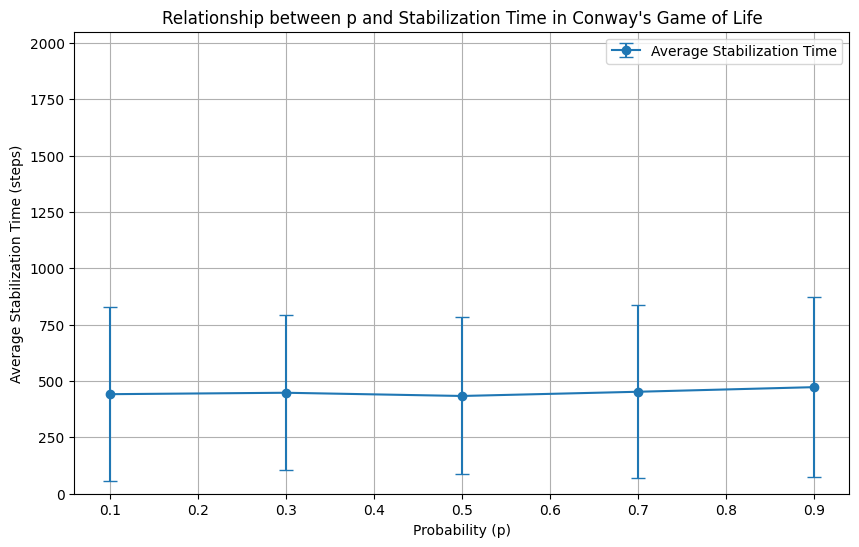

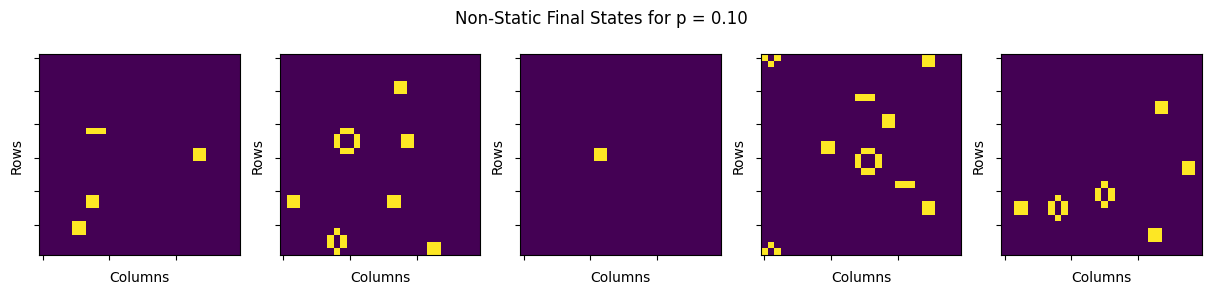

For p = 0.30, 498 out of 500 trials ended in a non-static, non-dead state.


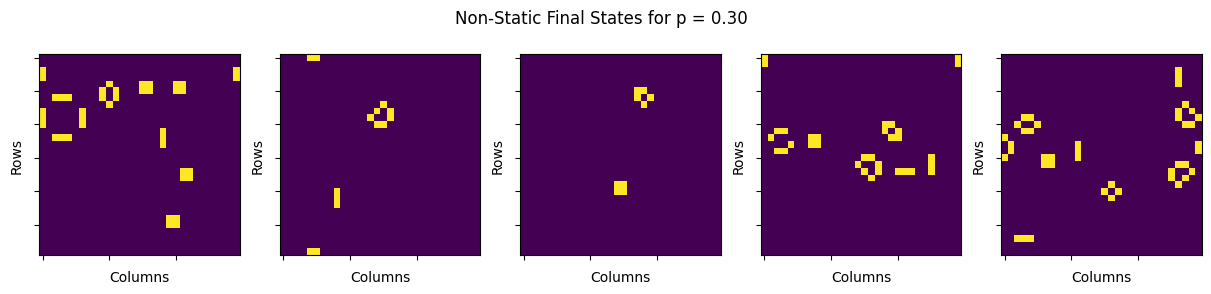

For p = 0.50, 500 out of 500 trials ended in a non-static, non-dead state.


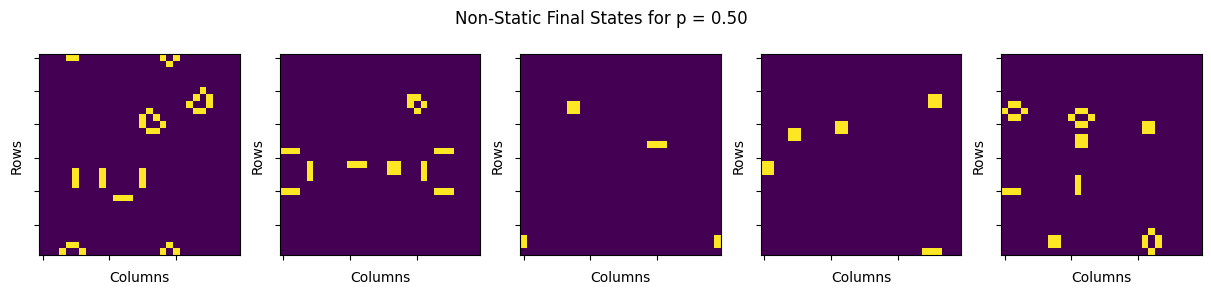

For p = 0.70, 499 out of 500 trials ended in a non-static, non-dead state.


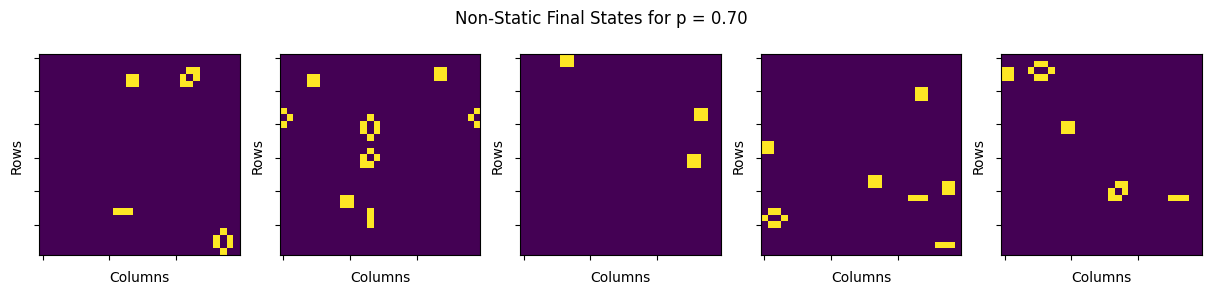

For p = 0.90, 500 out of 500 trials ended in a non-static, non-dead state.


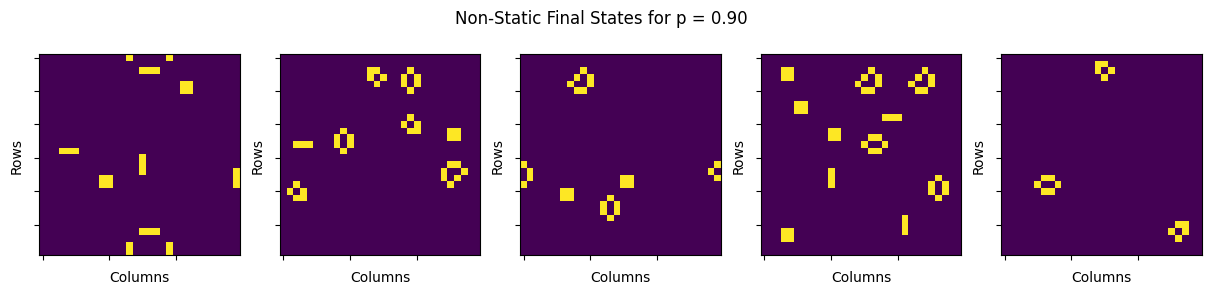


Summary Statistics:
p = 0.10:  Mean = 441.67,  Std Dev = 386.04
p = 0.30:  Mean = 448.03,  Std Dev = 344.21
p = 0.50:  Mean = 433.73,  Std Dev = 348.30
p = 0.70:  Mean = 452.44,  Std Dev = 384.69
p = 0.90:  Mean = 472.90,  Std Dev = 398.68
Script complete.


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d

# --- (Improved) Life Classes ---
#For colab notebook.
def plot_2d_array(data, axes=None, title='', cmap='viridis'):
    """ Plot a 2D array using imshow. """
    axes = axes or plt.gca()
    axes.imshow(data, cmap=cmap, interpolation='none')
    axes.set_title(title)
    axes.set_xlabel('Columns')
    axes.set_ylabel('Rows')
    # Turn off tick labels
    axes.set_xticklabels([])
    axes.set_yticklabels([])

class BetterLife2D_Faster(Life2D):  # Inherit from Life2D class
    def __init__(self, n_rows, n_cols=None):
        super().__init__(n_rows, n_cols)
        self.randomize_state(0.5)
        # Don't draw here initially!
    def step(self):
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        #This is where the magic happens:
        self.state = self.next_state[transitions] * self.state #Apply survival rule
        # Now add birth rule
        birth_transitions = (transitions == 3) & (self.state == 0) # Cells that *should* be born
        self.state[birth_transitions] = 1
        # NO DRAWING!
    def draw(self, axes=None, step=''): # Keep the draw method for later use
        axes = axes or plt.gca()
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")
    def randomize_state(self, p):
        self.state = np.random.choice([0, 1], size=self.state.shape, p=[1-p, p])
        # Don't draw here either!
    def load_pattern(self, x, y, pattern):
      pattern_height, pattern_width = pattern.shape
      self.state[x:x + pattern_height, y:y + pattern_width] = pattern
def random_life_faster(n_rows, n_cols=None, p=0.5):
    return BetterLife2D_Faster(n_rows, n_cols)

# --- Experiment Framework ---

def run_experiment(p_values, grid_size, max_steps, num_trials, cycle_detection_depth=10):
    print("Running run_experiment...") # DEBUG
    all_stabilization_times = []
    all_final_states = []

    for p_index, p in enumerate(p_values):  #Added enumerate here
        print(f"  Processing p = {p} (p_index = {p_index})")  # DEBUG
        trial_stabilization_times = []
        trial_final_states = []
        for trial in range(num_trials):
            print(f"    Running trial {trial + 1} of {num_trials}")  # DEBUG
            life = random_life_faster(grid_size, grid_size, p=p)  # Use your random_life function
            previous_states = []  # Store previous states for cycle detection
            stabilized_step = max_steps  # Assume max_steps if it doesn't stabilize

            for step in range(1, max_steps + 1):
                #print(f"      Step {step}")  # DEBUG (comment this out for speed, but keep it for now)
                life.step()

                # Check for stabilization (same as a previous state)
                for i, prev_state in enumerate(previous_states):
                    if np.array_equal(life.state, prev_state):
                        stabilized_step = step
                        print(f"      Stabilized at step {step} (matched state {i+1} steps back)")  # DEBUG
                        break  # Exit the inner loop
                if stabilized_step != max_steps:
                    break #exit outer loop

                # Add current state to history (keep only the last cycle_detection_depth states)
                previous_states.append(life.state.copy())
                if len(previous_states) > cycle_detection_depth:
                    previous_states.pop(0)  # Remove the oldest state

            trial_stabilization_times.append(stabilized_step)
            trial_final_states.append(life.state.copy())
        all_stabilization_times.append(trial_stabilization_times)
        all_final_states.append(trial_final_states)

    print("run_experiment complete.")  # DEBUG
    return all_stabilization_times, all_final_states

# --- Experiment Parameters (Tune These!) ---

p_values = [0.1, 0.3, 0.5, 0.7, 0.9]  # Keep these for now
grid_size = 30   # Increased grid size
max_steps = 2000  # Significantly increased max_steps
num_trials = 500  # Significantly increased num_trials
cycle_detection_depth = 20

# --- Run the Experiment ---
print("Starting experiment...") #DEBUG
try:
    results, final_states = run_experiment(p_values, grid_size, max_steps, num_trials, cycle_detection_depth)
    print("Experiment completed successfully.") #DEBUG
except Exception as e:
    print(f"An error occurred during the experiment: {e}")
    results = [] #Ensure results is defined
    final_states = []#Ensure final_states id defined


# --- Data Analysis and Plotting ---
print("Analyzing results...")#DEBUG
try:
    avg_stabilization_times = [np.mean(times) for times in results]
    std_devs = [np.std(times) for times in results]
except Exception as e:
    print(f"Error during data analysis {e}")
    avg_stabilization_times = [] #ensure defined
    std_devs = [] #ensure defined

plt.figure(figsize=(10, 6))
plt.errorbar(p_values, avg_stabilization_times, yerr=std_devs, fmt='o-', capsize=5, label='Average Stabilization Time')
plt.xlabel('Probability (p)')
plt.ylabel('Average Stabilization Time (steps)')
plt.title('Relationship between p and Stabilization Time in Conway\'s Game of Life')
plt.grid(True)
plt.ylim(0, max_steps + 50)  # Adjust y-axis limits as needed
plt.legend()


# --- Identify and Plot Non-Static Final States (Cycle Detection) ---
print("Checking for non-static final states...") #DEBUG
for p_index, p in enumerate(p_values):
    non_static_count = 0
    for final_state in final_states[p_index]:
        unique_elements = np.unique(final_state)
        if len(unique_elements) > 1:  # Not all zeros (not dead) and not all ones (full grid)
            if np.sum(final_state) > 0: #Must have some live cells
                non_static_count += 1
    print(f"For p = {p:.2f}, {non_static_count} out of {num_trials} trials ended in a non-static, non-dead state.")

    # --- Visualize non-static states ---
    if non_static_count > 0:
        fig, axes = plt.subplots(1, min(non_static_count, 5), figsize=(15, 3))  # Show up to 5 examples
        fig.suptitle(f"Non-Static Final States for p = {p:.2f}")
        for i in range(min(non_static_count, 5)):
            plot_2d_array(final_states[p_index][i], axes=axes[i])
        plt.show(block=True)



# --- Summary Statistics ---

print("\nSummary Statistics:")
for p, mean, std in zip(p_values, avg_stabilization_times, std_devs):
    print(f"p = {p:.2f}:  Mean = {mean:.2f},  Std Dev = {std:.2f}")

plt.show(block=True)
print("Script complete.") #DEBUG

## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add a `load_pattern(x, y, pattern)` method to your `BetterLife2D` class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [40]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """

# Ex. 3 your code here...
def load_pattern(self, x, y, pattern):
  """
  Loads a pattern into the Life state array at the specified coordinates.

    Args:
      x: The x-coordinate of the top-left corner of the pattern.
      y: The y-coordinate of the top-left corner of the pattern.
      pattern: The 2D numpy array representing the pattern.
  """
  pattern_height, pattern_width = pattern.shape
  self.state[x:x + pattern_height, y:y + pattern_width] = pattern

### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [22]:
# Ex. 3 define your patterns here...
glider = load_pattern(glider_pattern)
beehive = load_pattern("""
    010
    101
    101
    010
    """)
block = load_pattern("""
    11
    11
    """)
gosper_gun = load_pattern("""
    00000000000000000000000
00000001100000000001100
00000010010000000010000
00000010010001100100000
00000001010010010000000
00000000110000000000000
00000000000000000000000
""")

### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

20 frames
[(1, 639), (2, 541), (3, 547), (4, 506), (5, 497), (6, 432), (7, 431), (8, 398), (9, 381), (10, 374), (11, 366), (12, 361), (13, 367), (14, 365), (15, 376), (16, 388), (17, 378), (18, 389), (19, 381), (20, 359)]


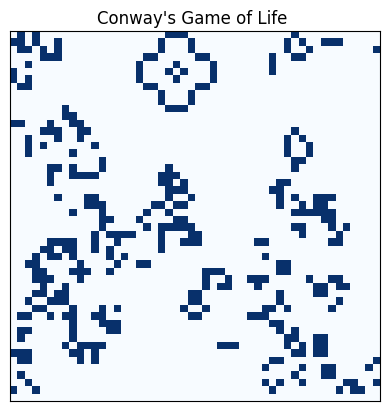

In [39]:
# Ex. 3 code for your experiment here
life = BetterLife2D(50)
life.load_pattern(10, 10, gosper_gun)
life.load_pattern(10, 10, glider)
life.load_pattern(20, 20, block)  # Place a block strategically

# Example: Track population count
population_count = []
for i in range(gol.frames):
    life.step()
    population_count.append((i+1, np.sum(life.state)))
print(f"{gol.frames} frames")
print(population_count)